# SaxaVord EO Challenge

Welcome to your challenge: Focussing on an Area of Interest (AOI) over the Faroe Islands, you can look at either: 

* Quantify the extent of algae bloom changes, and their impact on nearby Salmon Fishing Farms
* Quantify the extent of recent coastal erosion 

## Check Environment Active

In [ ]:
# Desktop UI
# The active environement should show this on the top RHS of your screen, below the LogOut button

In [1]:
# Conda
# The active environment will show a '*' next to it
!conda env list

# conda environments:
#
base                     C:\Users\s2448783\AppData\Local\miniforge3
satenv                   C:\Users\s2448783\AppData\Local\miniforge3\envs\satenv
saxa_env              *  C:\Users\s2448783\AppData\Local\miniforge3\envs\saxa_env
sense                    C:\Users\s2448783\AppData\Local\miniforge3\envs\sense
sense2020                C:\Users\s2448783\AppData\Local\miniforge3\envs\sense2020
testenv                  C:\Users\s2448783\AppData\Local\miniforge3\envs\testenv



In [ ]:
# Pip
!which pip
!which python # This should point to a python version inside the virtual env folder

## Import Packages

In [2]:
# RUN CELL IF USING CLOUD NOTEABLE ONLY
# !pip install -r requirements.txt

In [3]:
# Packages
import os
import glob
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Visualisation Params

# opens separate browser window to view images (won't work in noteable)
%matplotlib qt5

# show output in notebook
%matplotlib inline


# Sentinel 2

### The Data Folder Structure
Satellite imagery products are folders which contain satellite imagery data in a standardised way, including standard naming conventions for folders etc. Please see the SaxaVord PDF for an explanation of the Sentinel 2 naming convention. 

A single image  product of a region at DateTime YYYYMMDD-HHMMSS is packaged in a folder with a hierarchical file structure. In our case this is:

    |-S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212.SAFE *folder for a single image product*
        |-GRANULE
            |-L2A_T30VUQ_A036242_20220531T120405
                |-IMG_DATA
                    |- R10m  *resolution folders*
                        |-T30VUQ_20220531T120411_B02_10m.jp2 *individual band file*
                        |-T30VUQ_20220531T120411_B03_10m.jp2
                        |-...
                        |-T30VUQ_20220531T120411_TCI_10m.jp2 *TCI = true color image, multi-band file *

                    |- R20m
                        |-T30VUQ_20220531T120411_B02_20m.jp2
                        |-T30VUQ_20220531T120411_B03_20m.jp2
                        |-...
                    |- R60m
                        |-T30VUQ_20220531T120411_B02_60m.jp2
                        |-T30VUQ_20220531T120411_B03_60m.jp2
                        |-...
                        
                        
Data Notes:
* Once unzipped, the Sentinel 2 data is provided in a .SAFE directory - a format used by ESA.
* The actual image bands are .jp2 files.
* Each directory has multiple bands at multiple resolutions e.g. band 2 is provided at both 10m and 20m resolution in their respective directories.
* The filepath for each band is going to be very verbose and a bit annoying to track.


### Image Bands
* True Colour Images (TCI) are comprised of 3 bands, Red, Green and Blue (or RGB) - the visible light section of the Electromagnetic Spectrum. 

* Satellite sensors cover a far broader section of this spectrum, and therefore capture a larger number of bands. 

* Different phenomena on earth and within the atmosphere react differently to wavelengths across the spectrum (e.g. different bands), allowing us to make inferences about what is occuring below.

* Certain bands are therefore useful for different environmental analyses.

* Below is a table of the bands that Sentinel 2 collects, their resolutions and descriptions (from https://gisgeography.com/sentinel-2-bands-combinations/).

* More information about how the data is collected and the different bands can be found in the [Sentinel 2 user guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi) on the European Space Agency website.

|Band | Resolution | Central wavelength | Description |
|-----|------------|--------------------|-------------|
|B1	  |60 m	       |443 nm	            |Ultra Blue (Coastal and Aerosol)|
|B2	  |10 m	       |490 nm	            |Blue|
|B3	  |10 m	       |560 nm	            |Green|
|B4	  |10 m	       |665 nm	            |Red|
|B5	  |20 m	       |705 nm	            |Visible and Near Infrared (VNIR)|
|B6	  |20 m	       |740 nm	            |Visible and Near Infrared (VNIR)|
|B7	  |20 m	       |783 nm	            |Visible and Near Infrared (VNIR)|
|B8	  |10 m	       |842 nm	            |Visible and Near Infrared (VNIR)|
|B8a  |20 m	       |865 nm	            |Visible and Near Infrared (VNIR)|
|B9	  |60 m	       |940 nm	            |Short Wave Infrared (SWIR)|
|B10  |60 m	       |1375 nm             |Short Wave Infrared (SWIR)|
|B11  |20 m	       |1610 nm             |Short Wave Infrared (SWIR)|
|B12  |20 m	       |2190 nm             |Short Wave Infrared (SWIR)|


### Working with This Data
As a demonstration dataset we have six Sentinel 2 images, or tiles, in the starter_data folder, one for each month from March to August colected over the Faroe Islands.

To make the filepaths easier to work with, we shall give each image into it's own dictionary and store all filepaths there. This will enable easy referencing. The code below creates these dictionaries for you.

```
img_band_dict = {
                'img_folder': 'S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212',

                 'img_date': '20220531',
                 'img_time': '183212',
                 
                 'R10m':{'B02': 'T30VUQ_20220531T120411_B02_10m.jp2',
                         'B03': 'T30VUQ_20220531T120411_B03_10m.jp2',
                         ...
                         'TCI': 'T30VUQ_20220531T120411_TCI_10m.jp2'
                        },
                        
                  'R20m':{'B02': 'T30VUQ_20220531T120411_B02_20m.jp2',
                          'B03': 'T30VUQ_20220531T120411_B03_20m.jp2',
                           ...
                          },
                          
                  'R60m':{'B02': 'T30VUQ_20220531T120411_B02_60m.jp2',
                          'B03': 'T30VUQ_20220531T120411_B03_60m.jp2',
                           ...
                          }
                 }
                 
```
                 
**For Example:** To create a True Colour Image (RGB) at 10m resolution, we use Red (B04), Green (B03), Blue (B02). The individual bands can then be accessed:

```
## 10m resolution:
r_10m_filepath = img_band_dict['R10m']['B04']
r_10m_band_img = get_band(r_10m_filepath)

g_10m_filepath = img_band_dict['R10m']['B03']
g_10m_band_img = get_band(g_10m_filepath)

b_10m_filepath = img_band_dict['R10m']['B02']
b_10m_band_img = get_band(b_10m_filepath)
```

## Create Dictionaries of Band File Paths
* Here we automatically create the **img_band_dict** object above for every image
* The below assumes that all zipped data folders have being manually extracted

In [6]:
# set data directory (Mac)
# sen2dir = './starter_data/sentinel2/'

# windows
sen2dir = '.\\starter_data\\sentinel2\\'

# get list of image directories using the .SAFE extension as selector
lst = os.listdir(sen2dir)

img_dirs_lst = [x for x in lst if x.endswith('.SAFE')]


# Alternative if .SAFE not protected by your unzip
# img_dirs_lst = [x for x in lst if not x.endswith('.zip') and x[0]!='.']


# sort list by date so that bands are in the correct order
img_dirs_lst.sort(key = lambda x: x.split('_')[2])

print(img_dirs_lst)

# check number of directories found is as expected
print('Number of directories found:', len(img_dirs_lst))

['S2B_MSIL2A_20220327T120359', 'S2B_MSIL2A_20220419T121349', 'S2A_MSIL2A_20220531T120411', 'S2A_MSIL2A_20220607T115411', 'S2B_MSIL2A_20220705T120359', 'S2B_MSIL2A_20220831T115359']
Number of directories found: 6


In [7]:
# For each unzipped folder (a single day product), go in & extract all '.jp2' filepaths for the bands into a dictionary
# Store all dictionaries in a list (all_img_dicts)

all_img_dicts = []

## Select your join
# MAC
# jn = '/'

# Windows
jn = '\\'

# For each image folder in the Sentinel2 folder:
for img_folder in img_dirs_lst:

    ## List all band filenames
    # e.g. img_folder = 'S2B_MSIL2A_20220419T121349'
    date = img_folder[11:19]
    time = img_folder[20:26]
    f = sen2dir + jn + img_folder + jn

    # Sub-folders containing band data
    res_set = ['R10m', 'R20m', 'R60m']

    # Create a dictionary of the band names
    bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12','AOT','TCI','WVP','SCL']

    # Get all band files in the folder
    #  - glob = get all files in this folder (inc. nested)
    #  - filter to only include files within one of res_set folders
    #  - only keep '.jp2' type files 
    all_band_files = [ x for x in glob.glob(f + '**' + jn + '*', recursive=True) if any(res in x for res in res_set) and x.endswith('jp2')]

    # Create a new dictionary for the img
    img_band_dict = {'img_folder':img_folder,
                     'img_date':date,
                     'img_time':time}

    # Create a key for each resolution
    for res in res_set:
        img_band_dict[res] = {}

    # Assign all band filepaths to the img dict
    for band_file in all_band_files:

        # For each resolution, get all band filepaths
        for res in res_set:

            # Band file is in the resolution folder (contains res = 'R10m')
            if band_file.find(res)>=0:

                # Get the band type (B08, B8A, TCI etc) - assumes raw names of the band file have not being changed
                band_type = band_file[len(band_file)-11:-8]

                # Store e.g. img_band_dict['R10m']['B03'] = 'filepath/to/R10m/img_B03.jp2'
                img_band_dict[res][band_type] = band_file
                
    
    # Add img dictionary to list of dictionaries
    all_img_dicts.append(img_band_dict)
            

In [8]:
## Example: Single image dictionary and exploring its values

# Get the dictionary
img_day_dict = all_img_dicts[0]

# Understand its metadata 
print('date:',img_day_dict['img_date'])
print('time:',img_day_dict['img_time'])

print('path to 20m B05 Band (Red Edge):')
print('   ', img_day_dict['R20m']['B05'])

date: 20220327
time: 120359
path to 20m B05 Band (Red Edge):
    .\starter_data\sentinel2\\S2B_MSIL2A_20220327T120359\S2B_MSIL2A_20220327T120359_N0400_R066_T29VPK_20220327T163425.SAFE\GRANULE\L2A_T29VPK_A026404_20220327T120354\IMG_DATA\R20m\T29VPK_20220327T120359_B05_20m.jp2


In [9]:
## See which bands available at which resolution

print('R10m:',img_day_dict['R10m'].keys())
print('R20m:',img_day_dict['R20m'].keys())
print('R60m:',img_day_dict['R60m'].keys())

R10m: dict_keys(['AOT', 'B02', 'B03', 'B04', 'B08', 'TCI', 'WVP'])
R20m: dict_keys(['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B11', 'B12', 'B8A', 'SCL', 'TCI', 'WVP'])
R60m: dict_keys(['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'TCI', 'WVP'])


## Import Band Data and Pre-processing

* The single band files (B02, B03, B04,...) are 2D rasters. These are 2D numpy arrays with some associated metadata. 
* The composite band files e.g. TCI are 3D rasters with the third dimension representing the number of bands. 
* We will use Masked numpy arrays on which you can use most of the same numpy methods.

To handle rasters, we will use the `rasterio (rio)` package which is built on top of numpy specifically for working with geospatial data. There are other packages available such as `xarray`.

**Note** that unlike normal numpy arrays, rasterio takes the top Left Hand Side of your array as (0,0), then x is the rows downwards, and y is the columns right.

The [rasterio documentation](https://rasterio.readthedocs.io/en/latest/) provides lots of examples for common geospatial operations.

First, let's load a single band and its associated metadata into an array and 'Profile' object respectively. The 'Profile' object is essentially a dictionary and be accessed and manipulated in the same way.

In [10]:
# Extract single band into an array

def get_band(filepath): 
    with rio.open(filepath) as f:
        img = f.read(1, masked=True)
        metadata = f.profile
        
        return img, metadata

def print_band_properties(image, metadata):
    print('--> # bands:', metadata['count'])
    print('--> array type', type(image))
    print('--> datatype:', metadata['dtype'])
    print('--> nodata value:', metadata['nodata'])
    print('--> height:', metadata['height'], 'pixels')
    print('--> width:', metadata['width'], 'pixels')
    print('--> CRS:', metadata['crs'])
    print(20*'-')

    
# load example images and metadata and display properties to investigate

# single band image
b02_img, b02_metadata = get_band(img_day_dict['R10m']['B02'])
print('Band 2 (Blue) properties:')
print_band_properties(b02_img, b02_metadata)

# True Colour Image (TCI) with 3 bands
tci_img, tci_metadata = get_band(img_day_dict['R10m']['TCI'])
print('TCI properties:')
print_band_properties(tci_img, tci_metadata)

print('\nSummary statistics for Band 2:')
print(f'\nMin:\t{b02_img.min()}\nMax:\t{b02_img.max()}\nMean:\t{b02_img.mean():.2f}\nStdDev:\t{b02_img.std():.2f}\n')

b02_img

Band 2 (Blue) properties:
--> # bands: 1
--> array type <class 'numpy.ma.core.MaskedArray'>
--> datatype: uint16
--> nodata value: None
--> height: 10980 pixels
--> width: 10980 pixels
--> CRS: EPSG:32629
--------------------
TCI properties:
--> # bands: 3
--> array type <class 'numpy.ma.core.MaskedArray'>
--> datatype: uint8
--> nodata value: None
--> height: 10980 pixels
--> width: 10980 pixels
--> CRS: EPSG:32629
--------------------

Summary statistics for Band 2:

Min:	0
Max:	20048
Mean:	524.76
StdDev:	700.48



masked_array(
  data=[[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [1613, 1631, 1626, ..., 1159, 1156, 1161],
        [1562, 1567, 1576, ..., 1159, 1124, 1142],
        [1506, 1501, 1501, ..., 1165, 1122, 1162]],
  mask=False,
  fill_value=999999,
  dtype=uint16)

### Note: Masked Arrays

* We have imported the image as a **masked array**, but currently the mask isn't doing very much and simply says "False".
* Instead we would like the portions of the image where we don't have data to be **masked out** so they are not included in any calculations we do on the raster.

For Sentinel 2, 0 is is reserved for nodata, therefore we will mask all the zeroes so they are not included in any calculations we do on the rasters. To check this has worked we can compare the summary statistics for Band 2 before and after masking.

We also specify a 'fill_value' - usually a large (and often negative) number so that it is obviously not real data, and the corresponding metadata 'nodata' value is updated in the 'Profile' dictionary. This tells rasterio what value to write to file at nodata locations. We will use -9999 as the fill_value.

In order to do this we first need to update the datatype to enable the raster to store negative numbers. We will also update the metadata to match as we go along.

**NB** For this method of masking, mask == True if the data **is** masked.

In [11]:
def update_raster_dtype(raster, metadata, new_dtype='int16'):
    
    old_dtype = raster.dtype
    
    raster = raster.astype(new_dtype)
    metadata.update({
            "dtype": f'{new_dtype}'
        })
    
    print('Raster datatype has been updated from ', old_dtype, 'to ', raster.dtype)
    print('Metadata dtype has been updated to:', metadata['dtype'])
    
    return raster, metadata

def update_sen2_mask(raster, metadata, dtype='int16', fill_value=-9999):
    
    # update datatype for image and metadata
    raster, metadata = update_raster_dtype(raster, metadata, new_dtype=dtype)
    
    # update mask, fill value and metadata
    raster = np.ma.MaskedArray(raster, mask=(raster==0), fill_value=fill_value)
    metadata['nodata'] = fill_value

    print('Metadata nodata value has been updated to:', metadata['nodata'])
    
    return raster, metadata

# pre-process the previously loaded TCI and Band 2 images
tci_img, tci_metadata = update_sen2_mask(tci_img, tci_metadata)
b02_img, b02_metadata = update_sen2_mask(b02_img, b02_metadata)

print('\nSummary statistics for Band 2 after masking:')
print(f'\nMin:\t{b02_img.min()}\nMax:\t{b02_img.max()}\nMean:\t{b02_img.mean():.2f}\nStdDev:\t{b02_img.std():.2f}\n')

b02_img

Raster datatype has been updated from  uint8 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999
Raster datatype has been updated from  uint16 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999

Summary statistics for Band 2 after masking:

Min:	1
Max:	20048
Mean:	1422.16
StdDev:	231.35



masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [1613, 1631, 1626, ..., 1159, 1156, 1161],
        [1562, 1567, 1576, ..., 1159, 1124, 1142],
        [1506, 1501, 1501, ..., 1165, 1122, 1162]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-9999,
  dtype=int16)

**Note** that we can access the data and mask separately with the syntax below.

In [12]:
print('b02 data:\n', b02_img.data)
print('b02 mask:\n', b02_img.mask)

print('tci data:\n', b02_img.data)
print('tci mask:\n', b02_img.mask)

b02 data:
 [[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [1613 1631 1626 ... 1159 1156 1161]
 [1562 1567 1576 ... 1159 1124 1142]
 [1506 1501 1501 ... 1165 1122 1162]]
b02 mask:
 [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
tci data:
 [[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [1613 1631 1626 ... 1159 1156 1161]
 [1562 1567 1576 ... 1159 1124 1142]
 [1506 1501 1501 ... 1165 1122 1162]]
tci mask:
 [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False Fa

### Note: Bit-Depth & DataTypes (uint8, uint16, float64)

For RGB, integer pixel values take values [0, 255], yet the array values above its far higher. This is because the individual band data is recorded as Digital Number on the interval [0, 10000].

* **Traditional RGB pixels have 8-Bit Depth:** Each channel can take one of 256 values, so for RGB there are 256x256x256 possible colours. This is often encoded as datatype uint8 (2^8 = 256), which is the most memory efficient way to store values on this range. Note that since negative values are not meaningful in this context, it is an unsigned integer. Each channel in the TCI raster is stored with this datatype.
* **Satellite data tends to have a larger Bit Depth (12 or 16):** The other bands are encoded as uint16 because Digital Number is on the interval [0, 10000] and 2^16 = 65536.

**Why do we care?**
* Memory usage: Converting to a greater bit-depth will use more memory, both when writing a raster to file, and during raster calculations.
* However, it is important to check, and often set, your datatype explicitly when working with rasters to avoid unexpected behaviour that won't necessarily throw errors. For example:
    - When we set the nodata value above, if we try and set a value that is outwith the datatype range, it will default to the uint8 or uint16 max value without giving an error.
    - When performing arithmetic operations on the rasters, it can be useful to specify a float datatype to avoid rounding errors. This is often done automatically by numpy, but is worth checking. Numpy may also automatically convert to a less memory-efficient datatype such as float64, when only float32 is necessary.

## Inspect and Plot data

We will load an RGB composite to show some data inspection and plotting methods.

To have a quick look in RGB at a tile we can load the TCI file from each Sentinel image and plot it using the `rasterio.plot show()` method.

In [14]:
from rasterio.plot import show

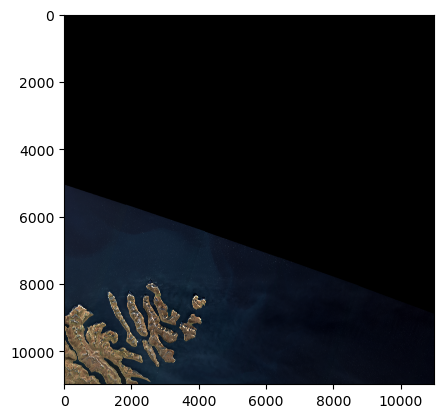

<Axes: >

In [17]:
with rio.open(img_day_dict['R10m']['TCI']) as f:
    rgb_img = f.read([1, 2, 3], masked=True)

show(rgb_img)

To create other composites, we can read in the bands separately. For example, a false colour composite uses B8, B4 and B3.

In [18]:
# read in B03 (green), B04 (red) and B08 (near-infrared)
b03, b03_metadata = get_band(img_day_dict['R10m']['B03'])
b04, b04_metadata = get_band(img_day_dict['R10m']['B04'])
b08, b08_metadata = get_band(img_day_dict['R10m']['B08'])

# mask
b03, b03_metadata = update_sen2_mask(b03, b03_metadata)
b04, b04_metadata = update_sen2_mask(b04, b04_metadata)
b08, b08_metadata = update_sen2_mask(b08, b08_metadata)

Raster datatype has been updated from  uint16 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999
Raster datatype has been updated from  uint16 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999
Raster datatype has been updated from  uint16 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999


### Normalisation

As matplotlib can only deal with data in the uint8 range (0, 255), or data on the interval [0, 1], we will divide the data by 10000 and **normalise** it to the [0, 1] interval as preparation for plotting. We can also clip the data to the mean ± 2 standard deviations for nice plotting. You can change the clip parameter to False to see the difference.

In [19]:
def normalise_band(raster, clip=True):
    
    raster = raster / 10000
    
    if clip is True:
        
        mn = raster.mean()
        sd = raster.std()
        upper = mn + (2*sd)
        lower = mn - (2*sd)
    
        raster[raster > upper] = upper
        raster[raster < lower] = lower
    
    return (raster - raster.min()) / (raster.max() - raster.min())

To plot the false colour composite, we can stack the images using `np.stack` so that `rasterio.plot`'s `show()` method will plot all three bands. 

**Note:** The stack must be in the correct band order to display correctly.
Because RGB is the classic true colour composite, we use the terminology red, green and blue channels to specify the order of band plotting. For a false colour composite we have:

1. red channel --> B08
2. green channel --> B04
3. blue channel --> B03

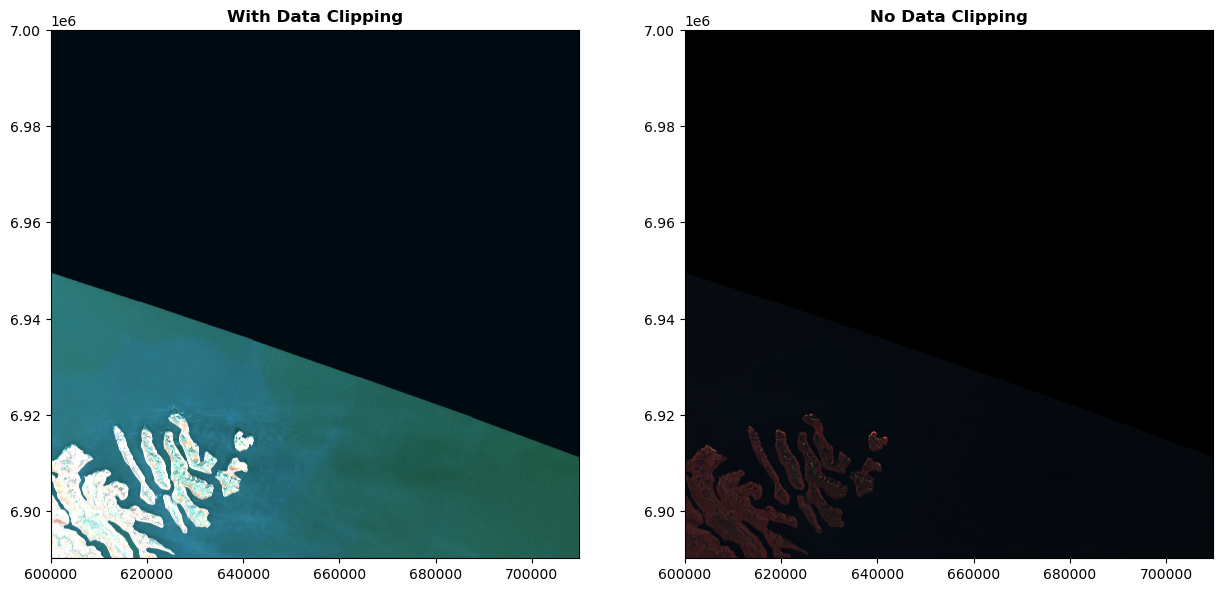

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# stack rasters for plotting
stack1 = np.stack([normalise_band(b08), normalise_band(b04), normalise_band(b03)])
stack2 = np.stack([normalise_band(b08, clip=False), normalise_band(b04, clip=False), normalise_band(b03, clip=False)])

show(stack1, transform=b08_metadata['transform'], ax=ax1, title="With Data Clipping")
show(stack2, transform=b08_metadata['transform'], ax=ax2, title="No Data Clipping")

plt.show()

### Histograms

A histogram of the data can be plotted for inspection using the `matplotlib hist()` method, or rasterio's built-in historgram plotter, `show_hist()`.

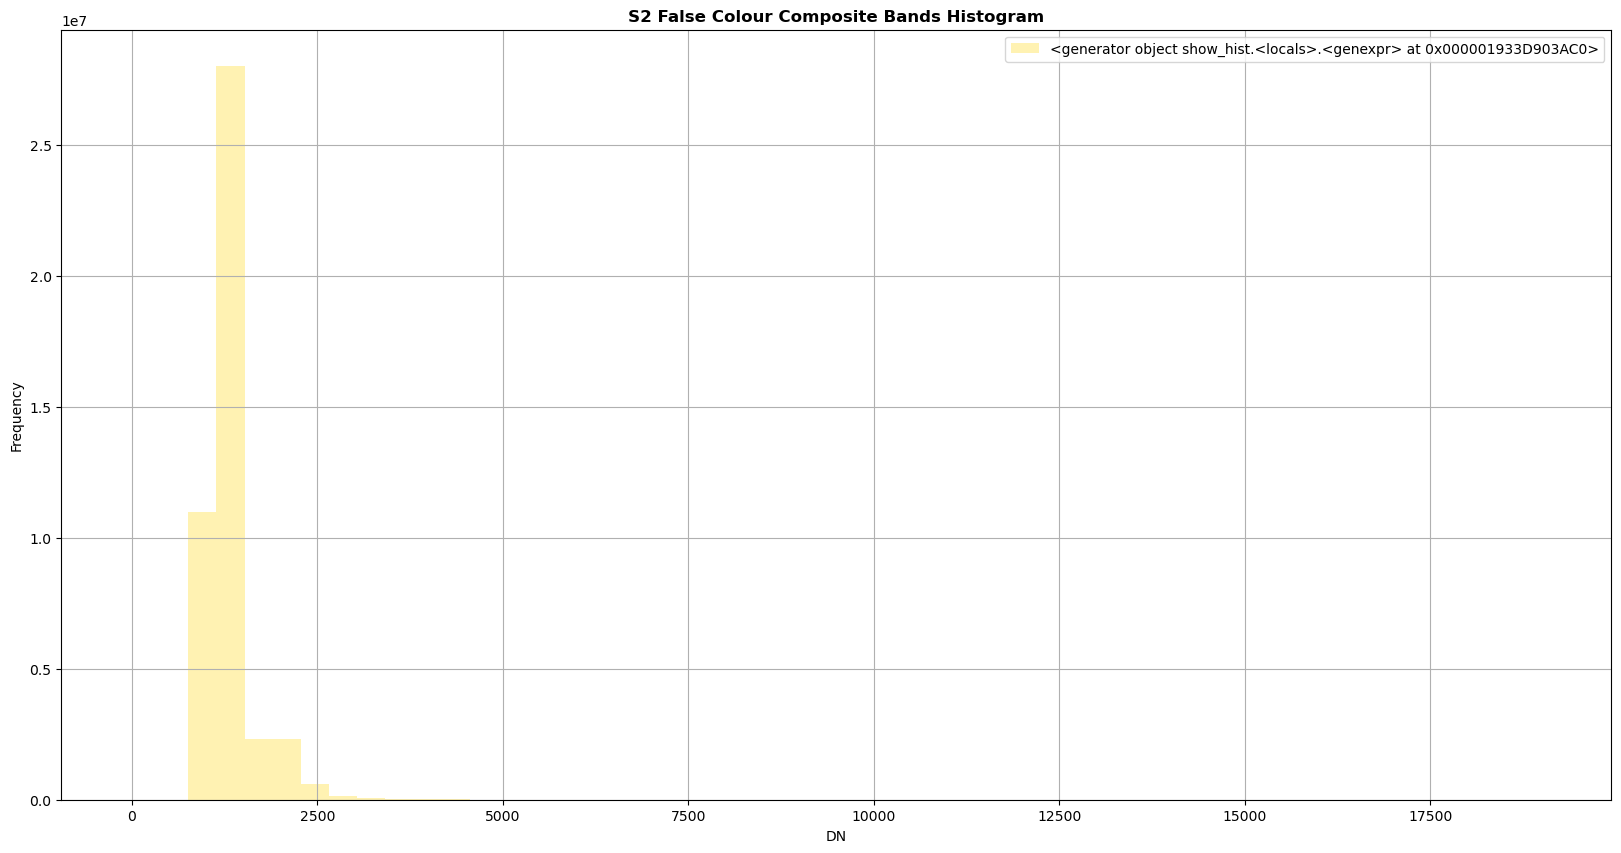

In [24]:
# rasterio
from rasterio.plot import show_hist

fig, ax_hist = plt.subplots(figsize=(20, 10))

show_hist(
    b03, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', ax=ax_hist, title='S2 False Colour Composite Bands Histogram')

KeyboardInterrupt: 

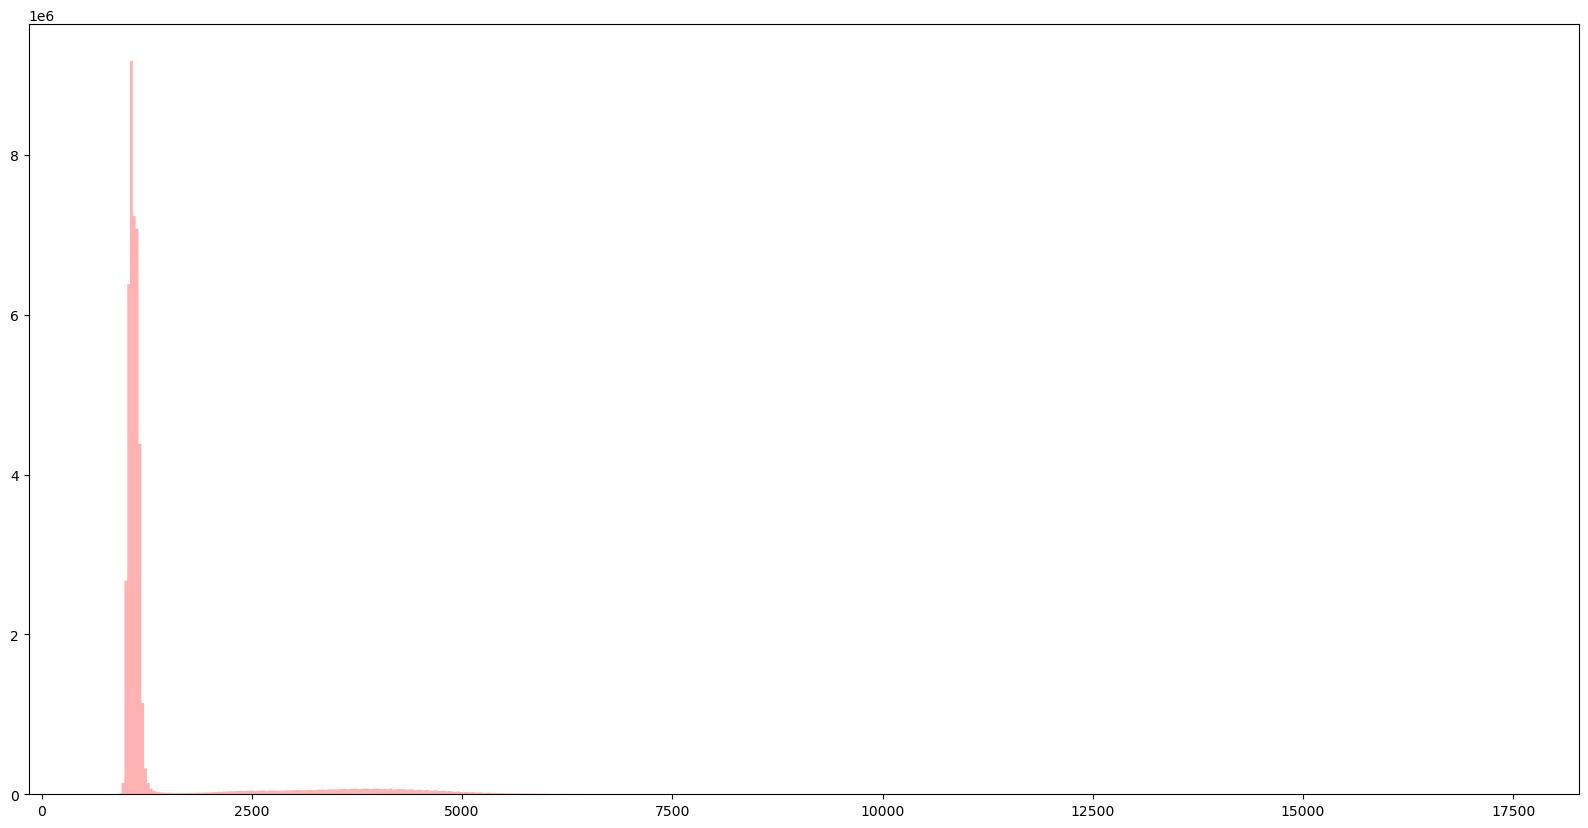

In [23]:
# matplotlib
fig, ax_hist = plt.subplots(figsize=(20, 10))

ax_hist.hist(b08.ravel(), bins=500, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, color='Red', label='Band 8 - NIR')
ax_hist.hist(b04.ravel(), bins=500, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, color='Green', label='Band 4 - Red')
ax_hist.hist(b03.ravel(), bins=500, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, color='Blue', label='Band 3 - Green')

ax_hist.tick_params(axis='both', which='major', labelsize=16)
ax_hist.set_xlabel('DN', fontsize=16)
ax_hist.set_ylabel('Frequency', fontsize=16)
ax_hist.set_title('S2 False Colour Composite Bands Histogram', fontsize=22)

plt.legend(fontsize=16)
plt.grid()
plt.show()

## Resampling - Changing the Spatial Resolution of a Band

Before resampling, the spatial resolution is 20.0 metres

After resampling, the spatial resolution is 10.0 metres



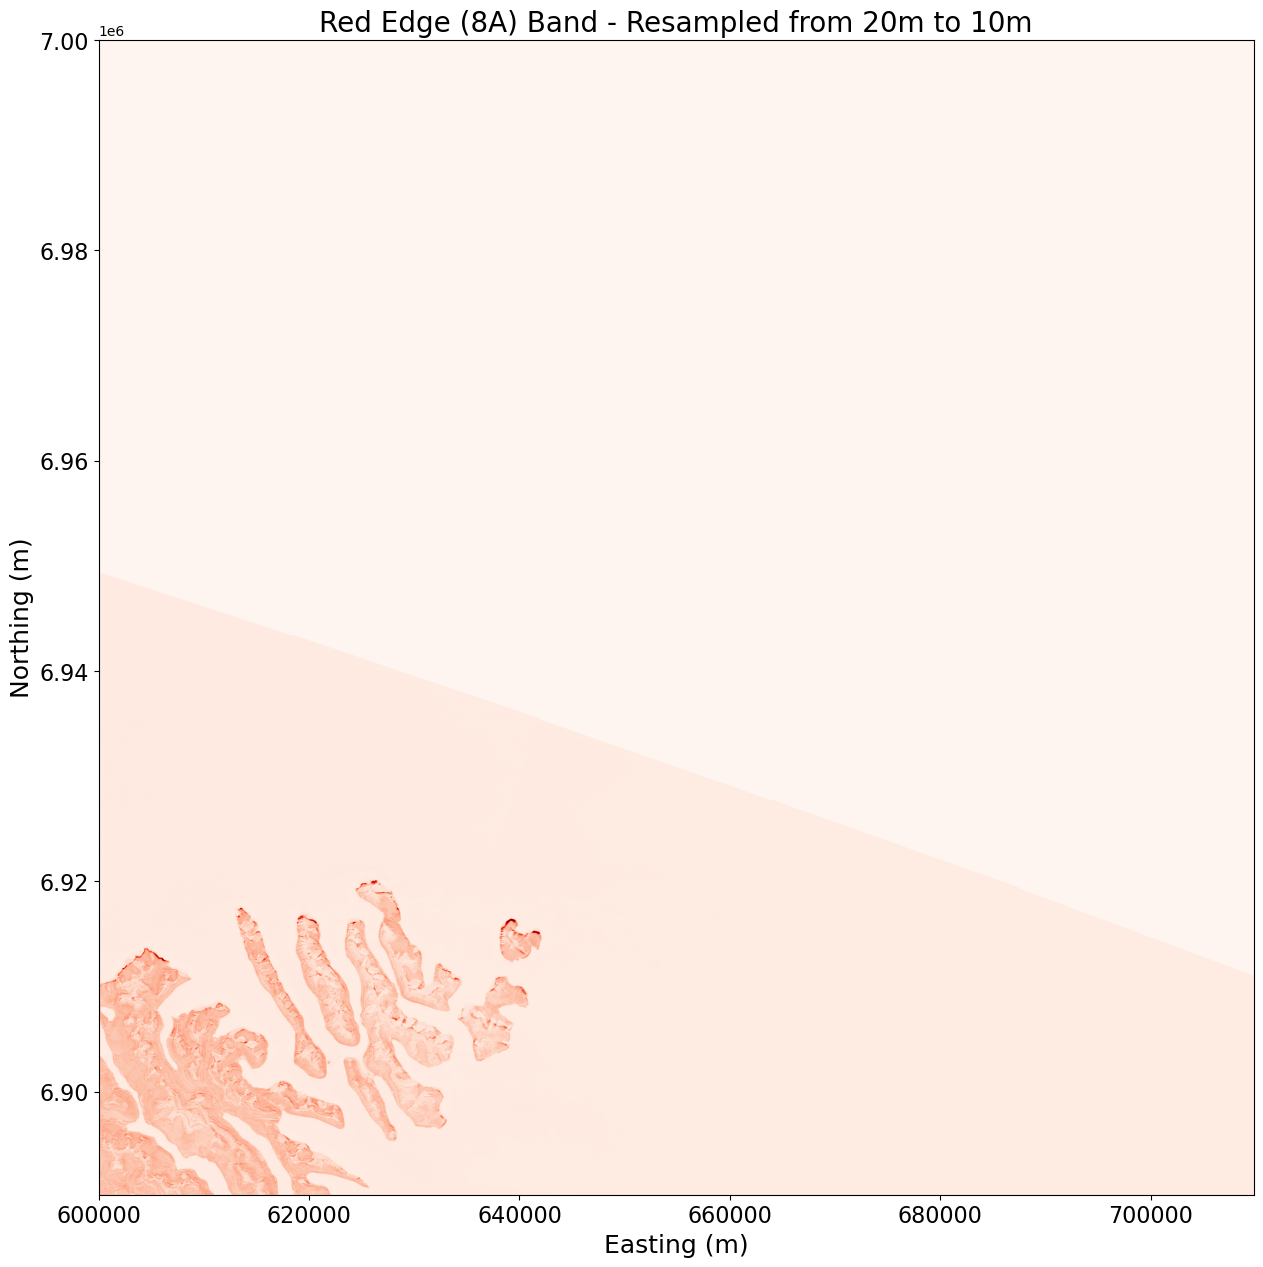

In [25]:
from rasterio.enums import Resampling

fig, ax = plt.subplots(figsize=(15, 15))

scale_factor = 2 # double spatial resolution

with rio.open(img_day_dict['R20m']['B8A']) as dataset:

    print(f'Before resampling, the spatial resolution is {dataset.res[0]} metres\n')
    
    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * scale_factor),
            int(dataset.width * scale_factor)
        ),
        resampling=Resampling.bilinear # Type of resampling used (choice here has an effect)
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    
print(f'After resampling, the spatial resolution is {dataset.res[0] / scale_factor} metres\n')

show(data, transform=transform, ax=ax, cmap='Reds')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Easting (m)', fontsize=18)
ax.set_ylabel('Northing (m)', fontsize=18)
ax.set_title('Red Edge (8A) Band - Resampled from 20m to 10m', fontsize=20)

plt.show()

## Calculations: Band Maths, Indices and Thresholding

Now that we know how to load bands from file into a numpy array, resample them, and plot them, we can use **band maths** to combine the bands in various ways and infer properties on the ground. Band maths creates new arrays be combining the bands with arithmetic operations. **Indices** are common band maths formulas that emphasise the spectral properties of different ground covers and are useful for identification and classification.

Some indices you might consider for your analysis include:

* Normalised Difference Vegetation Index (NDVI) 
    - (B8 - B4) / (B8 + B4)
    - Used for mapping vegetation because vegetation reflects strongly in the near IR (B8) and is strongly absorbed in red (B4)
    
* Normalised Difference Water Index
    - (B3 - B8) / (B3 + B8)
    - Used to detect water.

* Bare Soil Index (BSI)
    - ((B11 + B4) - (B8 + B2)) / ((B11 + B4) - (B8 + B2))
    - Used to detect bare ground, for example in crop monitoring, or landslide monitoring such as visualised in [this script](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/barren_soil/#).
    
You can see more indices [here](https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/).

Below is an example calculation for NDVI.

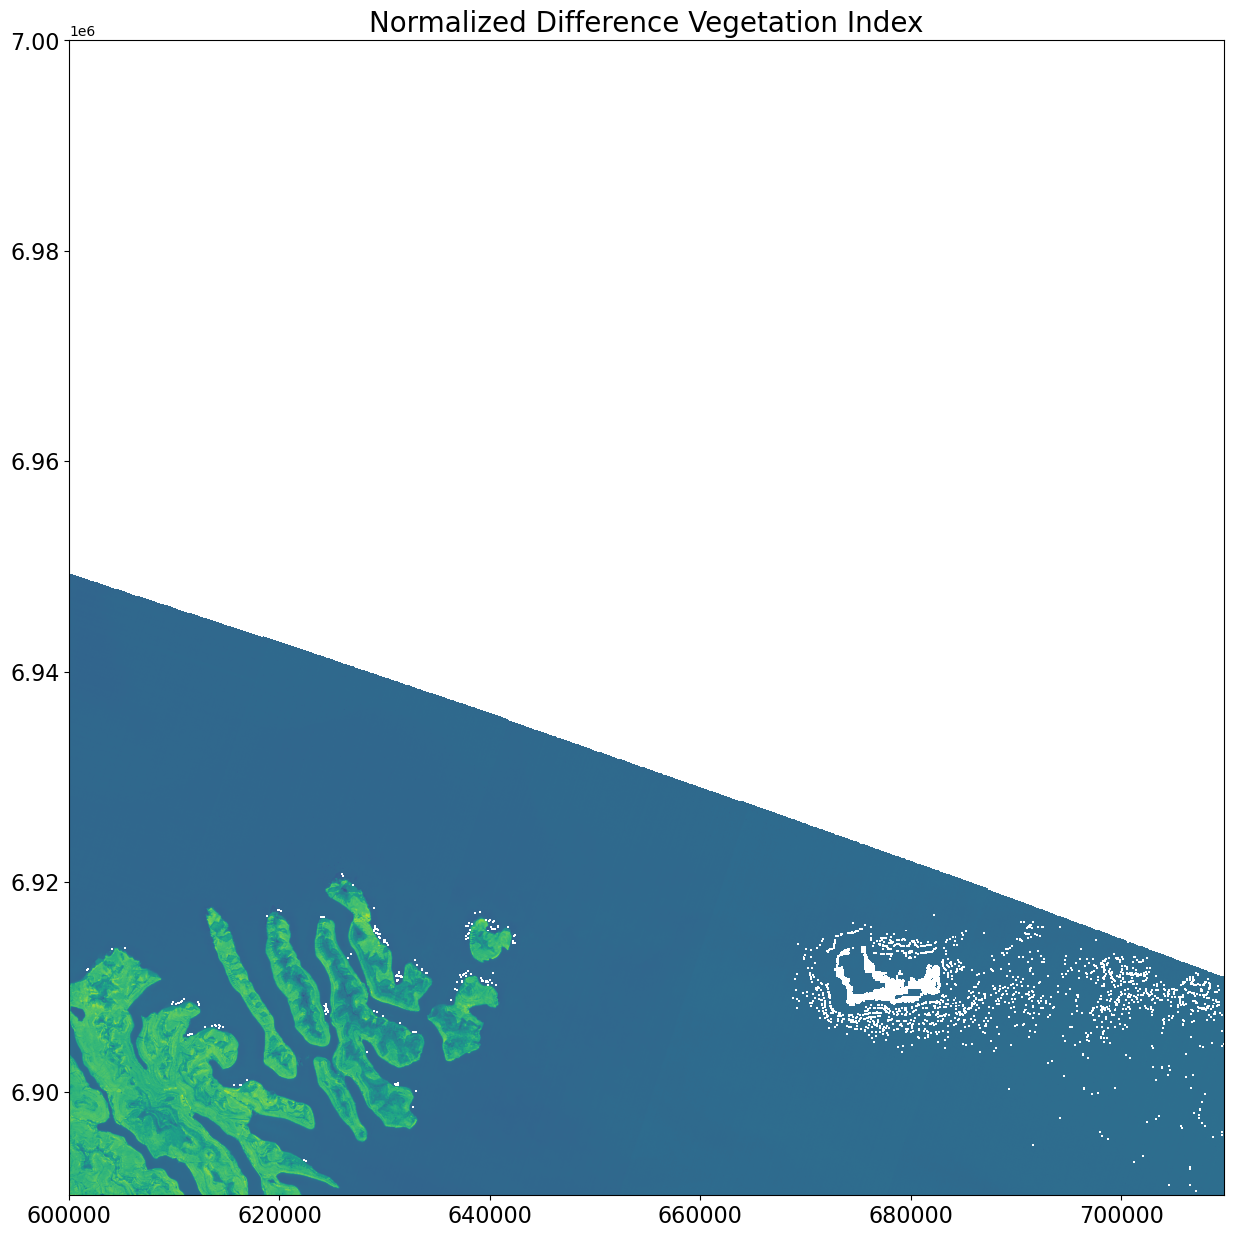

In [26]:
# Normlise bands before calculation
b08_norm = normalise_band(b08)
b04_norm = normalise_band(b04)

# Calculate NDVI
np.seterr(divide='ignore', invalid='ignore') # ignore error warning for dividing by zero
ndvi = np.divide(np.subtract(b08, b04), np.add(b08, b04))

# Plot
fig, ax_ndvi = plt.subplots(figsize=(15, 15))

show(ndvi, transform=b04_metadata['transform'], ax=ax_ndvi)

ax_ndvi.tick_params(axis='both', which='major', labelsize=16)
ax_ndvi.set_title('Normalized Difference Vegetation Index', fontsize=20)

plt.show()

It can also be useful to **threshold** your indices. For example, vegetated areas have NDVI > 0.2 (see [this link](https://www.mathworks.com/help/images/identify-vegetation-regions-using-interactive-ndvi-thresholding.html) for more detailed NDVI thresholds). One method of doing this is shown below by updating the mask, and checking that our new minimum value is 0.2.

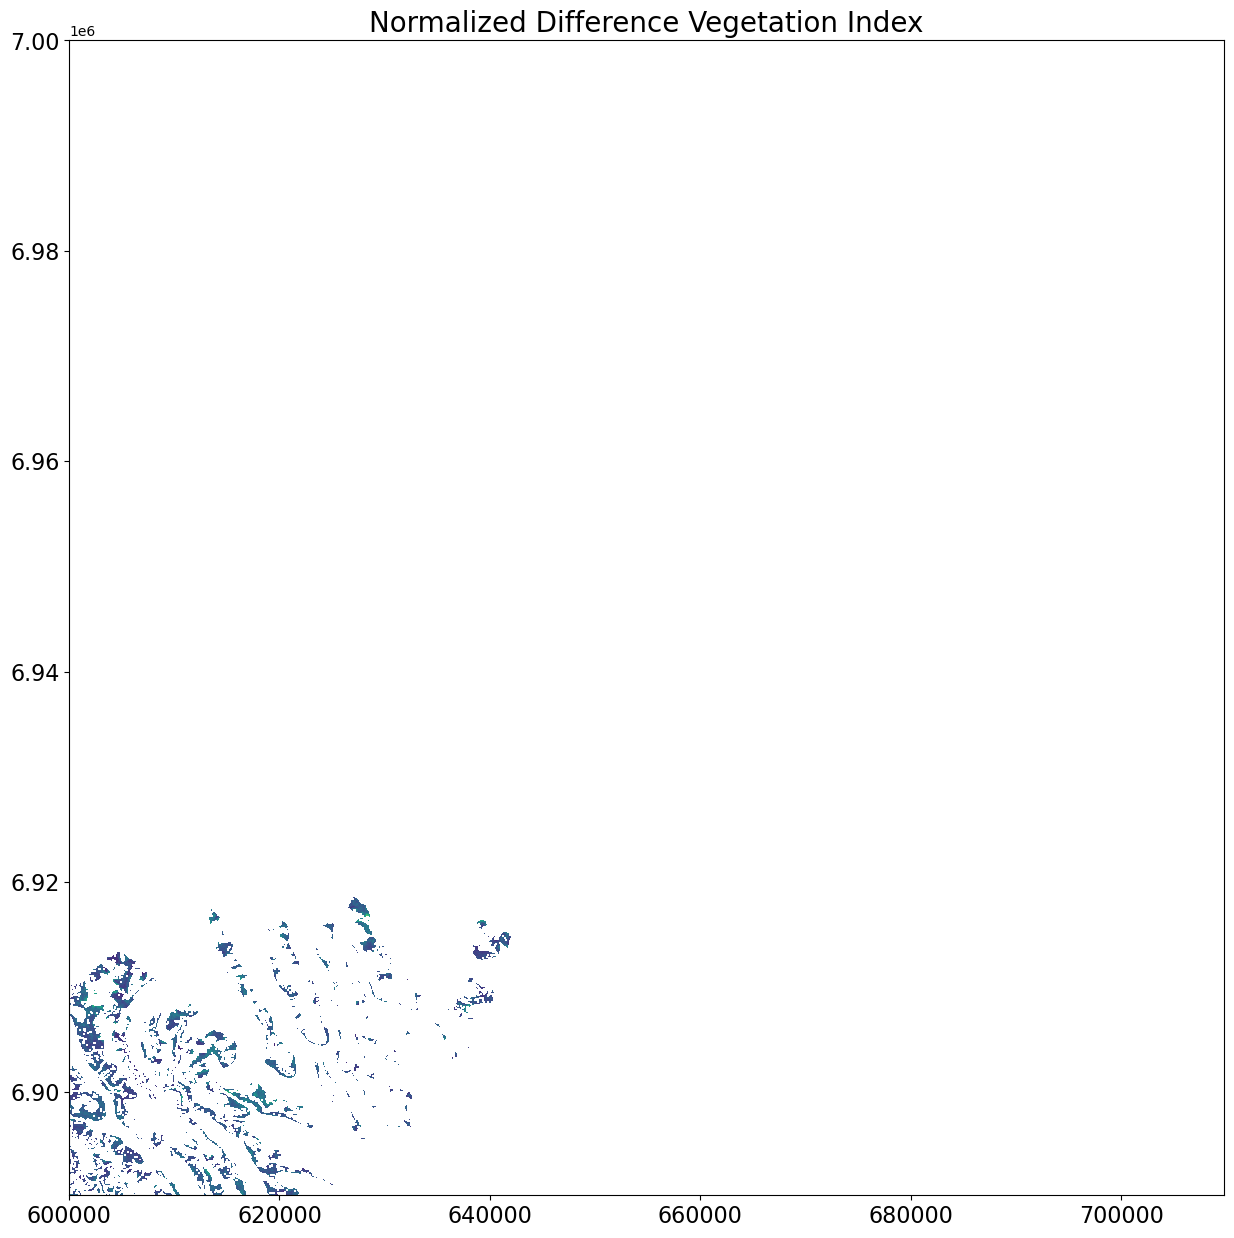

In [28]:
# update mask
ndvi.mask[ndvi.data < 0.2] = True

# sanity check
ndvi.min()

# plot vegetated areas as shown by NDVI
fig, ax_ndvi = plt.subplots(figsize=(15, 15))

show(ndvi, transform=b04_metadata['transform'], ax=ax_ndvi)

ax_ndvi.tick_params(axis='both', which='major', labelsize=16)
ax_ndvi.set_title('Normalized Difference Vegetation Index', fontsize=20)

plt.show()

# Vector Data

Most of the time, we are not interested in the entire satellite image, but would like to look at a specific area of interest. We can use vector data, polygons and points, to subset the raster data from above.

For spatial data, we use the `geopandas` package which is built on top of `pandas`. The full documentation can be found [here](https://geopandas.org/en/stable/docs/user_guide.html).

The code below imports the `geopandas` package and reads the two vector data files in the `starter_data/` directory as GeoDataFrames. These behave like regular dataframes but have an additional `geometry` column locating the data with reference to the coordinate system of the data.
1. A polygon of our area of interest (aoi).
2. A GeoDataFrame of three points with the fish farm locations.

In [29]:
import geopandas as gpd

In [30]:
# specify data filepaths (Mac)

# aoi_fp = './starter_data/vector_data/aoi.geojson'
# fish_farms_fp = './starter_data/vector_data/fish_farm_locations.geojson'

# Windows
aoi_fp = '.\\starter_data\\vector_data\\aoi.geojson'
fish_farms_fp = '.\\starter_data\\vector_data\\fish_farm_locations.geojson'

# read data into geodataframes
aoi = gpd.read_file(aoi_fp)
fish_farm_pts = gpd.read_file(fish_farms_fp)

print('Area of interest polygon:\n', aoi, '\n')
print('Fish farm location points:\n', fish_farm_pts)

Area of interest polygon:
                  Name                                           geometry
0  Faroe Salmon Farms  POLYGON ((-6.52870 62.33237, -6.85377 62.33817... 

Fish farm location points:
        Name                   geometry
0   Area 1   POINT (-6.84037 62.27180)
1    Area 2  POINT (-6.59578 62.25355)
2    Area 3  POINT (-6.60756 62.31270)


We can add new attributes, or columns, to our GeoDataFrame just as in a regular dataframe.

Let's add a new column to the fish farm locations GDF for the type of fish farmed. This will be used for plotting.

In [31]:
fish_farm_pts['fish'] = 'salmon'
print(fish_farm_pts)

       Name                   geometry    fish
0   Area 1   POINT (-6.84037 62.27180)  salmon
1    Area 2  POINT (-6.59578 62.25355)  salmon
2    Area 3  POINT (-6.60756 62.31270)  salmon


## CRS Checks

When working with geospatial datasets from different sources it is important to check that they are geographically referenced to the same coordinate reference system or CRS. We can easily convert between CRS's using the `to_crs()` method if there is a conflict.

In [32]:
band_img, band_metadata = get_band(img_day_dict['R20m']['B05'])

# print the coordinate reference system for each dataset
print('The CRS of the Sentinel 2 data is', band_metadata['crs'])
print('The CRS of the aoi polygon data is', aoi.crs)
print('The CRS of the fish farm location point data is', fish_farm_pts.crs)

# convert vector data crs to satellite data crs
aoi = aoi.to_crs(band_metadata['crs'])
fish_farm_pts = fish_farm_pts.to_crs(band_metadata['crs'])

# check that CRS's now match
print(band_metadata['crs'] == aoi.crs, band_metadata['crs'] == fish_farm_pts.crs)

The CRS of the Sentinel 2 data is EPSG:32629
The CRS of the aoi polygon data is epsg:4326
The CRS of the fish farm location point data is epsg:4326
True True


GeoDataFrames have an inbuilt set of attributes and methods that are useful for geospatial analysis. An example for polygon area is below. The full list is in the geopandas documentation [here](https://geopandas.org/en/stable/docs/user_guide/data_structures.html).

In [33]:
print('Area of aoi polygon in m2:\n', aoi.area)

Area of aoi polygon in m2:
 0    1.828258e+08
dtype: float64


## Plot satellite data with overlaid vector data

In [34]:
import shapely
import descartes

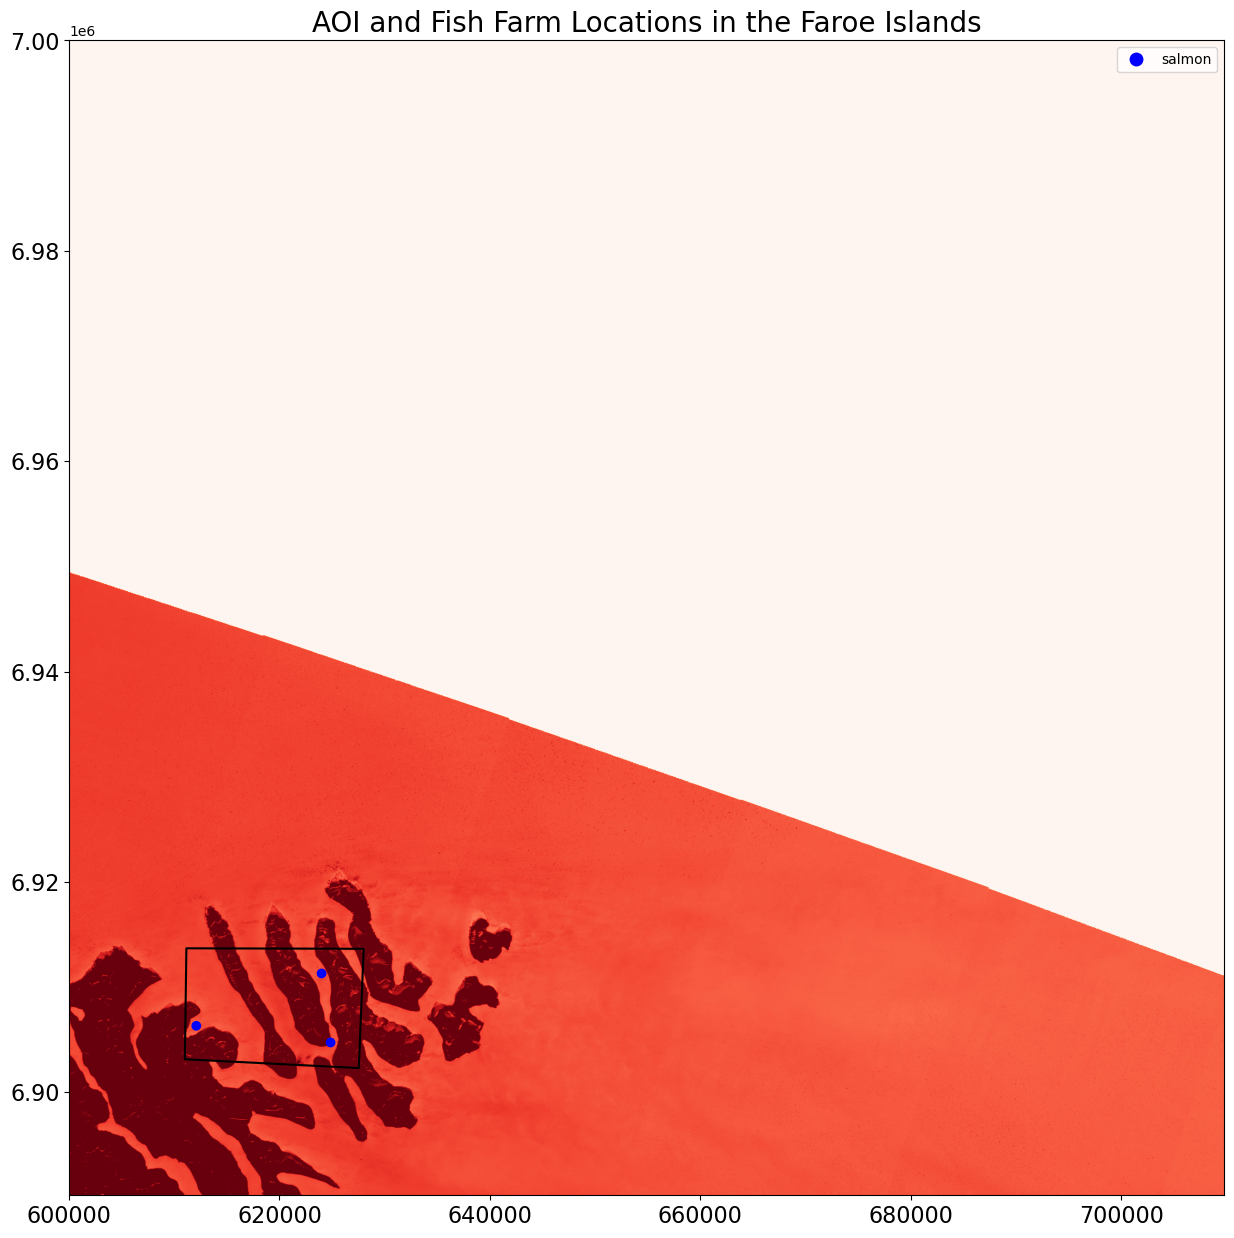

In [35]:
fig, ax_band = plt.subplots(figsize=(15, 15))

# plot raster with rasterio
show(normalise_band(band_img), transform=band_metadata['transform'], ax=ax_band, cmap="Reds")

# create colour map so we can specify the color of the fish farm points
from matplotlib.colors import LinearSegmentedColormap
clist = [(0.0, 0.0, 1.0), (0.0, 0.0, 1.0)] # use same colour twice (rgb blue) to get a single colour
cmap = LinearSegmentedColormap.from_list(name='single_cmap', colors=clist, N=1)

# plot vector layers on top
aoi.boundary.plot(ax=ax_band, edgecolor="Black")
fish_farm_pts.plot(ax=ax_band, column="fish", cmap=cmap, legend=True)

# other plot parameters
ax_band.tick_params(axis='both', which='major', labelsize=16)
ax_band.set_title('AOI and Fish Farm Locations in the Faroe Islands', fontsize=20)

plt.show()

## Zonal Statistics - Calculations on pixels within polygons

We can use the `rasterstats` package to extract descriptive statistics on raster pixel values within an area of interest or 'zone'. For example we could calculate statistics over the entire AOI polygon, just the land or water ([OpenStreetMap](https://osmdata.openstreetmap.de/data/water-polygons.html) have freely downloadable polygons for water and land), or we could [buffer](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) the fish farm locations to include some surrounding water.

In [36]:
from rasterstats import zonal_stats

# calculate statistics
statistics = zonal_stats(aoi, band_img, affine=band_metadata['transform'], nodata=-9999, stats='mean min max std', geojson_out=True)

# The geojson_out=True means the dictionary is output with the geometry
# Therefore we can reconstruct the GDF as below
aoi_with_statistics = gpd.GeoDataFrame.from_features(statistics, crs=aoi.crs)

print(aoi_with_statistics)

                                            geometry                Name  \
0  POLYGON ((628004.916 6913652.422, 611151.053 6...  Faroe Salmon Farms   

     min      max         mean         std  
0  908.0  17745.0  1943.783544  931.651119  


## Mask raster to polygon

In addition, we can mask the raster to our area of interest polygon using the `rasterio.mask.mask` module. We can also use the `crop` argument to crop the raster to the area of interest. This can be useful for cutting down on the number of large arrays stored in memory if you are working with multiple satellite images and for visualisation.

Let's modify the `get_band()` function to include this functionality. We can also incorporate the mask update so that our pre-processing is done in a single step.

In [37]:
from rasterio.mask import mask

def get_band(filepath, aoi=None, crop=False, dtype='int16', fill_value=-9999):
    
    # open dataset
    with rio.open(filepath) as f:
        # read in metadata
        metadata = f.profile
        
        if aoi is None:
            img = f.read(1, masked=True)
            
        else:
            img, transform = mask(f, aoi['geometry'], crop=crop, nodata=0, filled=True)
            img = img[0]
            # update metadata for new geometry
            metadata.update({
                        "height": img.shape[0],
                        "width": img.shape[1],
                        "transform": transform
                        })
        
        # update masking so we get a consistent product out
        img, metadata = update_sen2_mask(img, metadata, dtype=dtype, fill_value=-9999)
        
        return img, metadata

Raster datatype has been updated from  uint16 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999


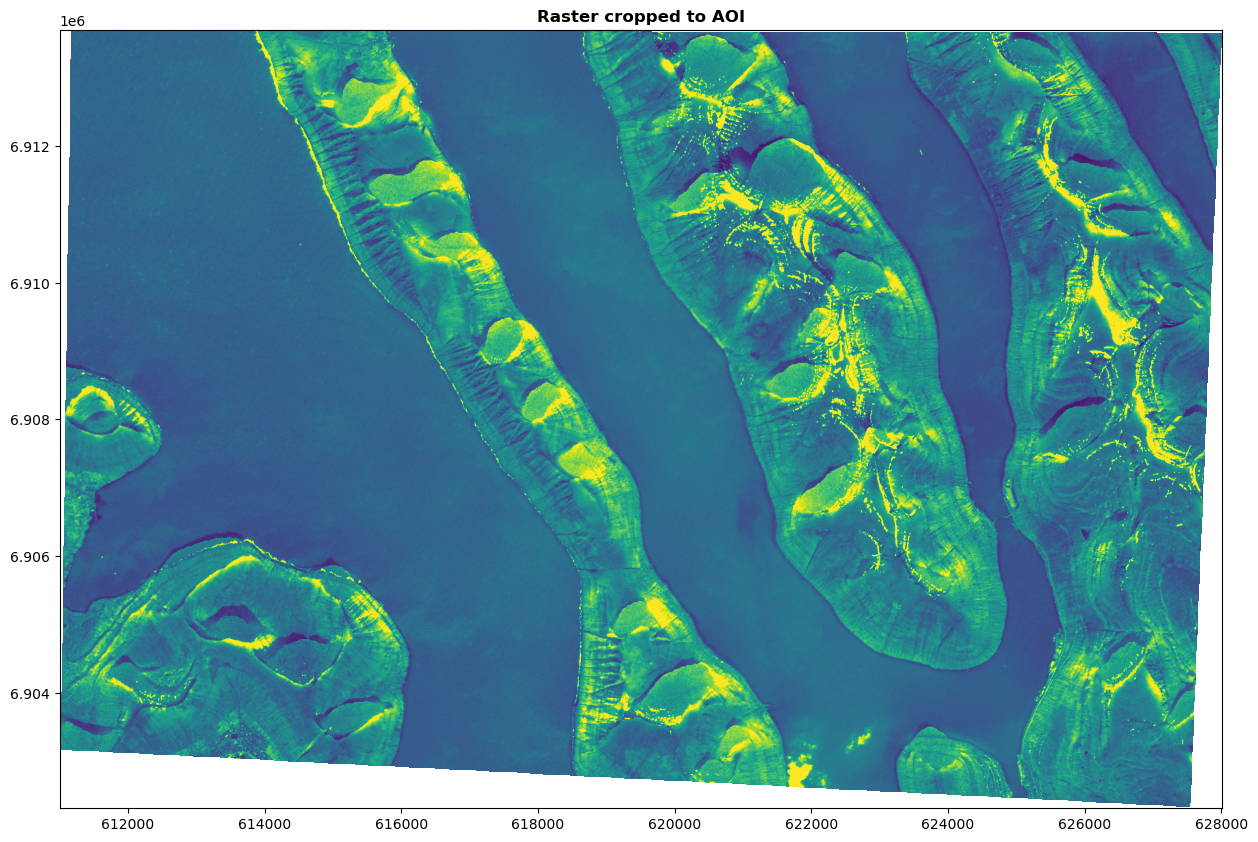

In [38]:
# Plot area of raster cropped to AOI
img_aoi, metadata_aoi = get_band(img_day_dict['R10m']['B02'], aoi=aoi, crop=True)

fig, ax_aoi = plt.subplots(figsize=(15, 15))

show(normalise_band(img_aoi), transform=metadata_aoi['transform'], ax=ax_aoi, title='Raster cropped to AOI')

plt.show()

## Writing out rasters

We can write out rasters using the code below. Rasters are usually written out in GeoTiff format `.tif`, a high quality image format which can also store the geospatial metadata.

* The `.filled()` is necessary in order to write out the masked values as the `fill_value` specified earlier.
* The 1 in the `dst.write()` specifies that we are writing out a single band.

In [41]:
# read in band
img, metadata = get_band(img_day_dict['R10m']['B02'])

# define the filepath to the outputs and a filename as a .tif

#outfp = 'path/to/output/file/example_filename.tif'

outfp = 'test_output.tif'

print('Writing to raster to TIF file locally')
with rio.open(outfp, 'w', **metadata) as dst:
        dst.write(img.filled(), 1)

Raster datatype has been updated from  uint16 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999
Writing to raster to TIF file locally


# Landsat

Although Sentinel 2 is fantastic, we may want data from before 2016 when Sentinel 2 was launched. The Landsat program provides freely accessible data with very similar bands to Sentinel 2 (see image below) starting in the 1970's with Landsat 1. Landsat 7, 8 and 9 are currently in operation and collecting data.

![Comparison of Landsat 7, 8 and Sentinel 2 bands](https://landsat.gsfc.nasa.gov/wp-content/uploads/2015/06/Landsat.v.Sentinel-2.png)

A potential downside of Landsat when compared with Sentinel 2 is the spatial resolution: the RGB and NIR bands have 30m resolution when compared to Sentinel 2's 10m. However, it is worth thinking if a high resolution is really necessary for your analysis as higher resolutions require more memory.

The time between images that cover the same ground, or **repeat time** is also longer - 16 days compared to Sentinel 2's 5 days.

Another reason to consider using Landsat data is cloud cover. In places where cloud cover is extremely frequent such as the Faroe Islands, as many images as possible can be useful for finding one where the AOI is not obscured!

We will have a brief look at some Landsat 8 data which covers 2013-present.

More information about the Landsat missions can be found on the [NASA website](https://landsat.gsfc.nasa.gov/) and [this page](https://www.usgs.gov/landsat-missions/landsat-8#:~:text=Landsat%208%20images%20have%2015,km%20(115%20mi)%20swath.) gives some more detailed info about Landsat 8.
You can follow the pdf guide in the repo to search for Landsat data on [USGS Earth Explorer](https://earthexplorer.usgs.gov/).

### The Data Folder Structure

A single image product is packaged in a folder with a flat file structure. The part of the filename that tells you the acquisition date is the first date in the filename: LXSS_LLLL_PPPRRR_**YYYYMMDD**_yyyymmdd_CC_TX. In our example we have:

    |- LC08_L2SP_209017_20180621_20200831_02_T1 *folder for a single image product*
        |- LC08_L2SP_209017_20180621_20200831_02_T1_SR_B1.TIF *individual band GeoTiffs*
        |- LC08_L2SP_209017_20180621_20200831_02_T1_SR_B2.TIF
        |-...
        |- LC08_L2SP_209017_20180621_20200831_02_T1_SR_B7.TIF
        |- LC08_L2SP_209017_20180621_20200831_02_T1_...QA...TIF *Quality assurance GeoTiffs*
        |- *other information files*
        
We will create a similar dictionary to the Sentinel 2 one above for the Landsat data.

In [47]:
# set data directory
# Mac
# landsat8dir = './starter_data/landsat8/'

# Windows
landsat8dir = '.\\starter_data\\landsat8\\'

# get list of image directories using the .SAFE extension as selector
lst = os.listdir(landsat8dir)
img_dirs_lst = [x for x in lst if x.endswith('T1')]
# sort list by date so that bands are in the correct order
img_dirs_lst.sort()

print(img_dirs_lst)

# check number of directories found is as expected
print('Number of directories found:', len(img_dirs_lst))

[]
Number of directories found: 0


['LC08_L2SP_209017_20180621_20200831_02_T1.tar',
 'LC08_L2SP_209017_20190827_20200826_02_T1.tar']

In [62]:
all_img_dicts = []

# For each image folder in the Sentinel2 folder:
for img_folder in img_dirs_lst:

    ## List all band filenames
    # e.g. img_folder = 'S2B_MSIL2A_20220419T121349'
    date = img_folder[17:25]
    f = landsat8dir + jn + img_folder + jn
    #print(f)

    # Create a dictionary of the band names
    bands = ['B01','B02','B03','B04','B05','B06','B07']

    # Get list of band 1-7 filepaths using glob 
    all_band_files = glob.glob(f'{f}{jn}*SR_B*')

    # Create a new dictionary for the img
    img_band_dict = {'img_folder':img_folder,
                     'img_date':date}

    # Assign all band filepaths to the img dict
    for band_file in all_band_files:

        # Get the band type (B08, B8A, TCI etc) - assumes raw names of the band file have not being changed
        band_type = band_file[len(band_file)-6:-4]

        # Store e.g. img_band_dict['B03'] = 'filepath/to/img_B03.TIF'
        img_band_dict[band_type] = band_file
                
    
    # Add img dictionary to list of dictionaries
    all_img_dicts.append(img_band_dict)
    
# Example filepath to band 3
all_img_dicts[0]['B3']
            

'./starter_data/landsat8//LC08_L2SP_209017_20180621_20200831_02_T1/LC08_L2SP_209017_20180621_20200831_02_T1_SR_B3.TIF'

We can now use rasterio in the same manner to open the landsat bands.

In [64]:
with rio.open(all_img_dicts[0]['B3']) as f:
    img = f.read(1, masked=True)
    metadata = f.profile
    
img

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)